# Implementing PID Control in Nonlinear Simulations

A task common to many control projects is to simulate the PID control of a nonlinear process. This notebook demonstrates the simulation of PID for an exothermic stirred tank reactor where the objective is to control the reactor temperature through manipulation of cooling water through the reactor cooling jacket.

![Exothermic Reactor](../images/408px-Agitated_vessel.png)

(Diagram By <a href="//commons.wikimedia.org/wiki/User:Daniele_Pugliesi" title="User:Daniele Pugliesi">Daniele Pugliesi</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=6915706">Link</a>)

## Model

The model consists of nonlinear mole and energy balances on the contents of the well-mixed reactor.

\begin{align*}
V\frac{dc}{dt} & = q(c_f - c )-Vk(T)c \\
\rho C_p V\frac{dT}{dt} & = wC_p(T_f - T) + (-\Delta H_R)Vk(T)c + UA(T_c-T)
\end{align*}

where $c$ is the reactant concentration, $T$ is the reactor temperature, and $T_c$ is the cooling jacket temperature. The model is adapted from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD), parameters defined and given in the table below.

The temperature in the cooling jacket is manipulated by the cooling jacket flow, $q_c$, and governed by the energy balance

\begin{align*}
\rho C_p V_c\frac{dT_c}{dt} & = \rho C_p q_c(T_{cf}-T_c) + UA(T - T_c)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c$, $T$, and $T_c$ give

\begin{align*}
\frac{dc}{dt} & = \frac{q}{V}(c_f - c)- k(T)c\\
\frac{dT}{dt} & = \frac{q}{V}(T_i - T) + \frac{-\Delta H_R}{\rho C_p}k(T)c + \frac{UA}{\rho C_pV}(T_c - T)\\
\frac{dT_c}{dt} & = \frac{q_c}{V_c}(T_{cf}-T_c) + \frac{UA}{\rho C_pV_c}(T - T_c)
\end{align*}

These are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |
| Coolant feed temperature | $T_{cf}$ | 300 | K |  |
| Nominal coolant flowrate | $q_c$ | 50 | L/min | primary manipulated variable |
| Cooling jacket volume | $V_c$ | 20 | liters | |

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
sns.set_context('talk')

Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
Cf = 1.0        # Inlet feed concentration [mol/L]
Tf  = 300.0     # Inlet feed temperature [K]
C0 = 0.5        # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tcf = 300.0     # Coolant feed temperature [K]
qc = 50.0       # Nominal coolant flowrate [L/min]
Vc = 20.0       # Cooling jacket volume

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(X,t):
    C,T,Tc = X
    dC = (q/V)*(Cf - C) - k(T)*C
    dT = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*C + (UA/V/rho/Cp)*(Tc - T)
    dTc = (qc/Vc)*(Tcf - Tc) + (UA/Vc/rho/Cp)*(T - Tc)
    return [dC,dT,dTc]

## Simulation 1. Same Initial Condition, different values of $q_c$

The given reaction is highly exothermic. If operated without cooling, the reactor will reach an operating temperature of 500K which leads to significant pressurization, a potentially hazardous condition, and possible product degradation. 

The purpose of this first simulation is to determine the cooling water flowrate necessary to maintain the reactor temperature at an acceptable value. This simulation shows the effect of the cooling water flowrate, $q_c$, on the steady state concentration and temperature of the reactor.  We use the scipy.integrate function `odeint` to create a solution of the differential equations for entire time period.

In [2]:
# visualization
def plotReactor(t,X):
    plt.subplot(1,2,1)
    plt.plot(t,X[:,0])
    plt.xlabel('Time [min]')
    plt.ylabel('gmol/liter')
    plt.title('Reactor Concentration')
    plt.ylim(0,1)

    plt.subplot(1,2,2)
    plt.plot(t,X[:,1])
    plt.xlabel('Time [min]')
    plt.ylabel('Kelvin');
    plt.title('Reactor Temperature')
    plt.ylim(300,520)

Once the visualization code has been established, the actual simulation is straightforward.

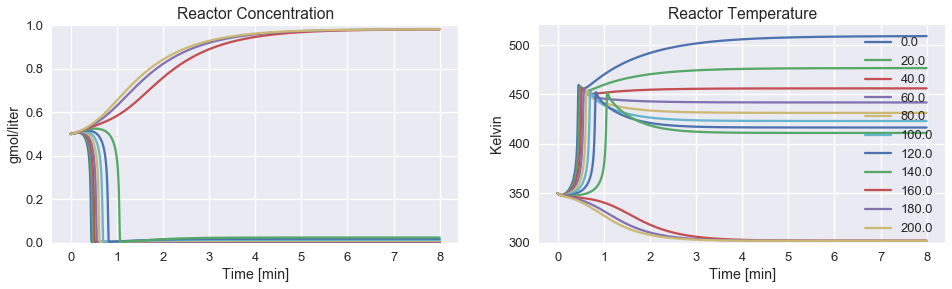

In [3]:
IC = [C0,T0,Tcf]                        # initial condition
t = np.linspace(0,8.0,2000)             # simulation time grid

qList = np.linspace(0,200,11)

plt.figure(figsize=(16,4))              # setup figure 
for qc in qList:                        # for each flowrate q_c
    X = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,X)                    # plot the results
    
plt.legend(qList)

The results clearly show a strongly nonlinear behavior for cooling water flowrates in the range from 140 to 160 liters per minute. Here we expand on that range to better understand what is going on.

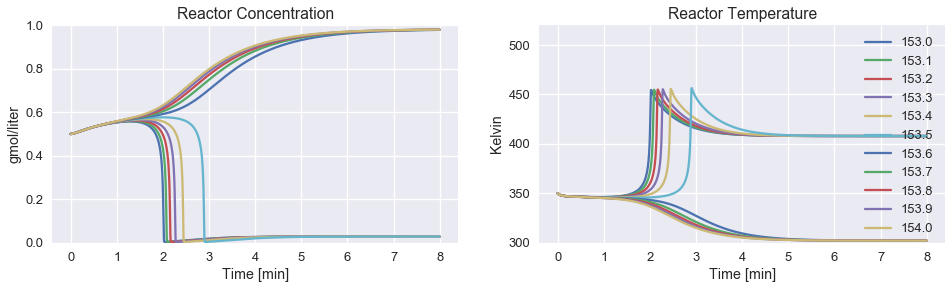

In [4]:
IC = [C0,T0,Tcf]                        # initial condition
t = np.linspace(0,8.0,2000)             # simulation time grid

qList = np.linspace(153,154,11)

plt.figure(figsize=(16,4))              # setup figure 
for qc in qList:                        # for each flowrate q_c
    X = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,X)                    # plot the results
    
plt.legend(qList)

There's a clear bifurcation when operated without feedback control. At cooling flowrates less than 153.7 liters/minute, the reactor goes to a high conversion steady state with greater than 95% conversion and a reactor temperature higher than about 410K. Coolant flowrates less than 153.8 liters/minute result in uneconomic operation at low conversion.

For the remainder of this notebook, our objective will be to achieve stable operation of the reactor at a high conversion steady state but with an operating temperature below 400 K, an operating condition that does not appear to be possible without feedback control.

## Simulation 2.  Fixed Time Grid

Introducing feedback control requires a change in the simulation strategy. 

The new approach will be to break the simulation interval up into small time steps of length $dt$.  At each breakpoint a PID control calculation will be performed, the coolant flow updated, then `odeint` will be used to simulate the reactor up to the next breakpoint.

The following cell demontrates the simulation strategy assuming a constant coolant flowrate. Note the use of Python lists to log simulation values for later plotting.

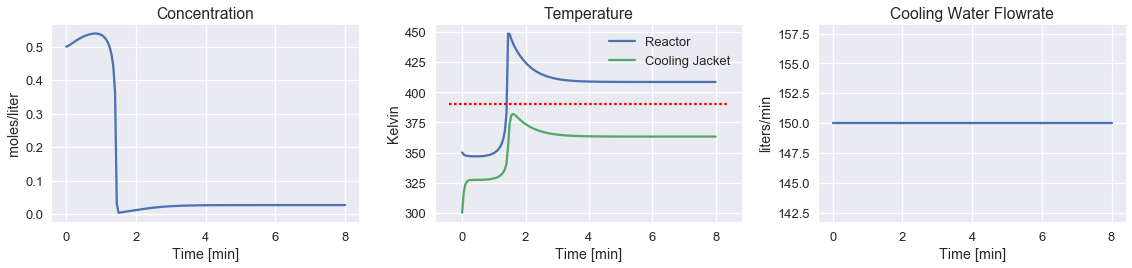

In [10]:
# set initial conditions and cooling flow
IC = [C0,T0,Tcf]
qc = 150

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# create python list to log results
log = []

# start simulation
c,T,Tc = IC
for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    log.append([t,c,T,Tc,qc])                      # log data for later plotting
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]   # start at t, find state at t + dt

def qplot(log):
    log = np.asarray(log).T
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(log[0],log[1])
    plt.title('Concentration')
    plt.ylabel('moles/liter')
    plt.xlabel('Time [min]')

    plt.subplot(1,3,2)
    plt.plot(log[0],log[2],log[0],log[3])
    if 'Tsp' in globals():
        plt.plot(plt.xlim(),[Tsp,Tsp],'r:')
    plt.title('Temperature')
    plt.ylabel('Kelvin')
    plt.xlabel('Time [min]')
    plt.legend(['Reactor','Cooling Jacket'])

    plt.subplot(1,3,3)
    plt.plot(log[0],log[4])
    plt.title('Cooling Water Flowrate')
    plt.ylabel('liters/min')
    plt.xlabel('Time [min]')
    plt.tight_layout()

qplot(log)

## Simulation 3.  Proportional-Integral-Derivative Control

Proportional-Integral-Derivative (PID) control is the workhorse of the process control industry. In standard form, the PID algorithm would be written

$$q_c(t) = \bar{q}_c - K_c\left[(T_{sp}-T) + \frac{1}{\tau_I}\int_0^t (T_{sp}-T)dt' + \tau_D\frac{d(T_{sp}-T)}{dt} \right]$$

For the control reactor temperature, note the controller is 'direct-acting' such that a positive excursion of the reactor temperature $T$ above the setpoint $T_{sp}$ is compensated by an increase in coolant flow, and vice-versa. Thus a negative sign appears before the term $K_c$ contrary to the usual textbook convention for negative feedback control.

The practical implementation of PID control is generally facilitated by a number of modifications.

#### Independent Parameters

A common practice is to introduce an independent parameterization for each fo the P, I, and D terms.  Rewriting, the control equation becomes

$$q_c(t) = \bar{q}_c - \left[k_P(T_{sp}-T) + k_I\int_0^t (T_{sp}-T)dt' + k_D\frac{d(T_{sp}-T)}{dt} \right]$$

where

\begin{align*}
k_P & = K_c \\
k_I & = \frac{K_c}{\tau_I} \\
k_D & = K_c\tau_D
\end{align*}

#### Setpoint Weighting

Step changes in setpoint $T_{sp}$ can produce undesired 'kicks' and 'bumps' if PID control is implemented directly using in standard form. It is common practice to introduce setpoint weighting factors for the proportional and derivative terms. This can be written as 

$$q_c(t) = \bar{q}_c - \left[k_Pe_P(t) + k_I\int_0^t e_I(t')dt' + k_D\frac{e_D(t)}{dt} \right]$$

where

\begin{align*}
e_P(t) & = \beta T_{sp}(t) - T(t) \\
e_I(t) & = T_{sp}(t) - T(t) \\
e_D(t) & = \gamma T_{sp}(t) - T(t)
\end{align*}

Common practice is to set $\gamma = 0$ which eliminates derivative action based on change in the setpoint. This feature is sometimes called 'derivative on output'. This almost always a good idea in process control since it avoids the 'derivative kick' associated with a change in setpoint.

In practice, the term $\beta$ is generally tuned to meet the specific application requirements. In this case, where setpoint tracking is not a high priority, setting $\beta = 0$ is a reasonable starting point.

#### Discrete Time Implementation

The simulation strategy adopted here requires a discrete time implementation of PID control. For a sampling time $dt$, the PID algorithm becomes

$$q_c(t_k) = \bar{q}_c - \left[k_Pe_P(t_k) + k_Idt\sum_0^{t_k} e_I(t_{k'}) + k_D\frac{e_D(t_k)-e_D(t_{k-1})}{dt} \right]$$

Implementation is further streamlined by computing changes is $q_c(t_k)$

$$\Delta q_c(t_k) = q_c(t_k) - q_c(t_{k-1})$$

Computing the differences

$$\Delta q_c(t_k) = -\left[k_P(e_P(t_k)-e_P(t_{k-1})) + k_I\ dt\ e_I(t_k) + k_D\frac{e_D(t_k) - 2e_D(t_{k-1}) + e_D(t_{k-2})}{dt}\right]$$

#### Bounded Control

A final consideration is that the coolant flows have lower and upper bounds of practical operation. 

$$q_c = \max(q_{c,min},\max(q_{c,max},q_c)) $$



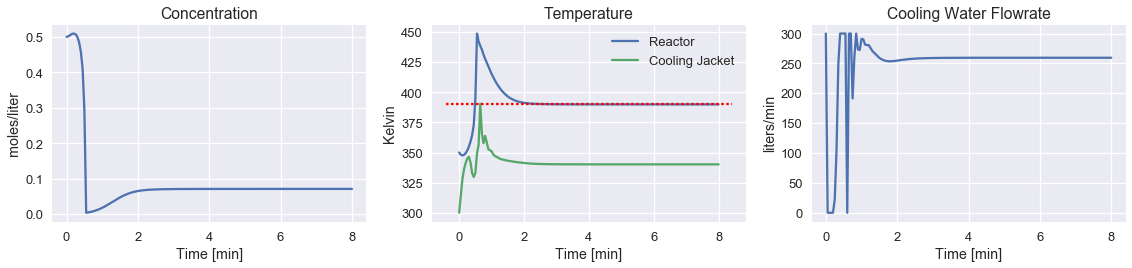

In [11]:
# setpoint
Tsp = 390

# set initial conditions and cooling flow
IC = [C0,T0,Tcf]
qc = 150

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# control saturation
qc_min = 0                            # minimum possible coolant flowrate
qc_max = 300                          # maximum possible coolant flowrate
def sat(qc):                          # function to return feasible value of qc
    return max(qc_min,min(qc_max,qc))

# control parameters
kp = 40
ki = 80
kd = 5
beta = 0
gamma = 0

eP_ = 0
eD_ = 0
eD__ = 0

# create python list to log results
log = []

# start simulation
c,T,Tc = IC
for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    # PID control calculations
    eP = beta*Tsp - T
    eI = Tsp - T
    eD = gamma*Tsp - T
    qc -= kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt
    qc = sat(qc)
    
    # log data and update state
    log.append([t,c,T,Tc,qc])
    c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
    # save data for PID calculations
    eD__ = eD_
    eD_ = eD
    eP_ = eP

qplot(log)

## Simulation 4. Interactive Controller Tuning

In this example, PID control is used to stabilize an otherwise unstable steady state, thereby allowing the reactor to operate at temperature and conversion that would not be possible without control. The acheivable operating conditions are limited by the controller tuning and the limits on the available control action.

The following simulation provides for the interactive adjustment of reactor setpoint temperature and the proportional, integral, and derivative control gains. Adjust these in order to answer the following questions:

1. What is the minimum achieveable temperature setpoint for the reactor with conversion greater than 80%?  What limits the ability to reduce the temperature setpoint even further?

2. Adjust the temperature setpoint to 420K.  Adjust the controller gains for satisfactory closed-loop performance.  Repeat the exercise for a setpoint of 380K. How is the behavior different?  What happens when when the proportional gain is set too small?  Explain what you see.

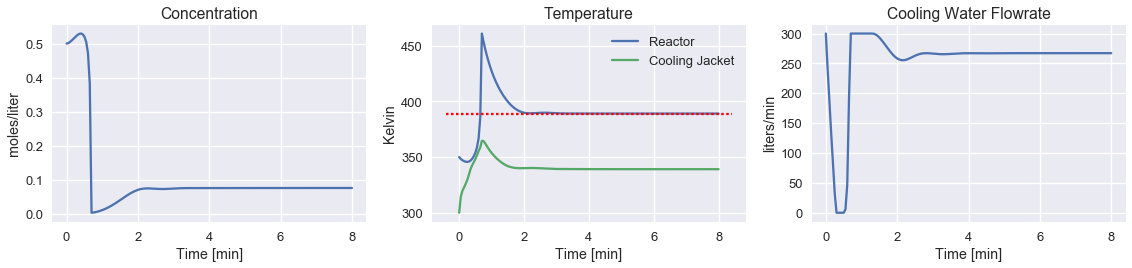

In [17]:
from ipywidgets import interact

def sim(Tsetpoint,kp,ki,kd):
    global Tsp, qc
    Tsp = Tsetpoint
    
    # control parameters
    beta = 0
    gamma = 0

    eP_ = 0
    eD_ = 0
    eD__ = 0

    # create python list to log results
    log = []

    # start simulation
    c,T,Tc = IC
    for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
        # PID control calculations
        eP = beta*Tsp - T
        eI = Tsp - T
        eD = gamma*Tsp - T
        qc -= kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt
        qc = sat(qc)
    
        # log data and update state
        log.append([t,c,T,Tc,qc])
        c,T,Tc = odeint(deriv,[c,T,Tc],[t,t+dt])[-1]     # start at t, find state at t + dt
    
        # save data for PID calculations
        eD__ = eD_
        eD_ = eD
        eP_ = eP

    qplot(log)
    
interact(sim,Tsetpoint = (360,420),kp = (0,80), ki=(0,160), kd=(0,10));